## 目录
* GRU结构
* GRU tensorflow手写数字识别

GRU（Gated Recurrent Unit）在2014年被提出，是LSTM的一个常用变体。GRU在过去的实践和应用中效果与lstm相当，且GRU结构更为简单、训练速度更快，因此GRU是lstm非常流行的一个变体。

## GRU结构

GRU cell结构包含2个门，分别为更新门$z_t$和重置门$r_t$。

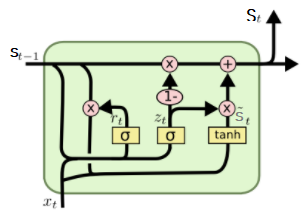

图中公式：

$r_t = \sigma(W_rs_{t-1}+U_rx_t)$  
$z_t = \sigma(W_zs_{t-1}+U_zx_t)$  
$\tilde{s_t}= tanh(W*(r_t*s_{t-1})+x_tU)$  
$s_t = z_t*s_{t-1}+(1-z_t)*\tilde{s_t}$

图注释：
* $\tilde{s_t}:$ t时刻GRU神经元的候选状态
* $s_t$：t时刻GRU神经元的状态输出
* 重置门$r_t$：决定如何把新的输入与之前的记忆相结合。重置门全为0时，候选状态只和该时刻输入X有关；重置门全为1时，候选状态由上一时刻状态和该时刻输入$x_t$共同影响。
* 更新门$z_t$：对先前记忆和该时刻输入选择性保留或遗忘。更新门全为0时，清除之前状态，更新候选状态为当前状态；更新门全为1时，完全保留之前状态，忽略该时刻输入$x_t$。
* 重置门为全1，更新门全为0时就是普通RNN的形式

## GRU tensorflow手写数字识别

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.set_random_seed(35)
mnist = input_data.read_data_sets('/home/chineseNER/jupyter/Tensorflow入门/dataset/MNIST_data', one_hot=True)

# hyperparameters设置模型参数，该参数是确定模型训练方式的
lr = 0.001
training_iters = 100000
batch_size = 128

n_inputs = 28   # MNIST data input (img shape: 28*28)28维
n_steps = 28    # time steps28行，每次读一行数据训练
n_hidden_units = 128   # neurons in hidden layer
n_classes = 10      # MNIST classes (0-9 digits)

# tf Graph input，placehoder定义变量，hold住变量，在执行节点时传入数据给该变量
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) #none表示输入图片张数不确定
y = tf.placeholder(tf.float32, [None, n_classes])
# 初始化参数，该参数在模型训练过程中会不断更新，最后达到最优
weights = {
    # 生成维度是(28, 128)的标准正太分布，mean=0，stddev=1
    'in': tf.Variable(tf.random_normal([n_inputs, n_hidden_units])),
    # (128, 10)
    'out': tf.Variable(tf.random_normal([n_hidden_units, n_classes]))
}
biases = {
    # (128, )
    'in': tf.Variable(tf.constant(0.1, shape=[n_hidden_units, ])),
    # (10, )
    'out': tf.Variable(tf.constant(0.1, shape=[n_classes, ]))
}


def RNN(X, weights, biases):
    # 输入层
    ########################################

    # transpose the inputs shape from
    # (128 batch ,28 steps, 28 inputs) ==> (128 batch * 28 steps, 28 inputs)
    X = tf.reshape(X, [-1, n_inputs])

    # into hidden
    # X_in = (128 batch * 28 steps, 128 hidden)
    X_in = tf.matmul(X, weights['in']) + biases['in']
    # X_in ==> (128 batch, 28 steps, 128 hidden)
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])

    # 隐藏层
    ##########################################

    # BasicLSTMCell定义单个cell
    cell = tf.nn.rnn_cell.GRUCell(n_hidden_units)
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    #dynamic_rnn函数将cell连成RNN 网络
    outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, initial_state=init_state)

    # 输出层：输出logits
    #############################################
    #results = tf.matmul(final_state[1], weights['out']) + biases['out']
    
    # unpack to list [(batch, outputs)..] * steps
    outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
    results = tf.matmul(outputs[-1], weights['out']) + biases['out']    # shape = (128, 10),每张图片10个logit值

    return results

#损失函数是整个minibatch的目标类别和预测类别之间的交叉熵,
pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
train_op = tf.train.AdamOptimizer(lr).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

import time
start_time = time.time()
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    step = 0
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape([batch_size, n_steps, n_inputs])
        sess.run([train_op], feed_dict={
            x: batch_xs,
            y: batch_ys,
        })
        if step % 20 == 0:
            print('step:',step,'accuracy:',sess.run(accuracy, feed_dict={
            x: batch_xs,
            y: batch_ys,
            }))
        step += 1
print("--- %s seconds ---" % (time.time() - start_time))

Extracting /home/chineseNER/jupyter/Tensorflow入门/dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/chineseNER/jupyter/Tensorflow入门/dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/chineseNER/jupyter/Tensorflow入门/dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/chineseNER/jupyter/Tensorflow入门/dataset/MNIST_data/t10k-labels-idx1-ubyte.gz
step: 0 accuracy: 0.109375
step: 20 accuracy: 0.664062
step: 40 accuracy: 0.765625
step: 60 accuracy: 0.867188
step: 80 accuracy: 0.8125
step: 100 accuracy: 0.867188
step: 120 accuracy: 0.882812
step: 140 accuracy: 0.859375
step: 160 accuracy: 0.859375
step: 180 accuracy: 0.90625
step: 200 accuracy: 0.921875
step: 220 accuracy: 0.960938
step: 240 accuracy: 0.90625
step: 260 accuracy: 0.921875
step: 280 accuracy: 0.953125
step: 300 accuracy: 0.929688
step: 320 accuracy: 0.9375
step: 340 accuracy: 0.9375
step: 360 accuracy: 0.96875
step: 380 accuracy: 0.960938
step: 400 accuracy: 0.976562
step: 420 accuracy: 0.953125

## 参考文献
https://docs.google.com/presentation/d/1UHXrKL1oTdgMLoAHHPfMM_srDO0BCyJXPmhe4DNh_G8/pub?start=false&loop=false&delayms=3000&slide=id.g24bcaec3b0_0_4356  